In [1]:
# ! pip install seaborn pyarrow h2o

In [2]:
import pylab as p
import numpy as np
import pandas as pd
import seaborn as sns
import pyspikelib.utils as spkutil
import pyspikelib.mpladeq as mpladeq

import os
import os.path as osp

from pathlib import Path

sns.set(font_scale=1.7, style='ticks')
mpladeq.beautify_mpl()

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [4]:
np.random.seed(15)

In [5]:
datapath = Path('../data')

wake_data = spkutil.load_parquet(datapath / 'wake.parq')
sleep_data = spkutil.load_parquet(datapath / 'sleep.parq')

In [6]:
data = {}

data['wake_train'], data['wake_test'] = spkutil.split_by_spikes(wake_data, ratio=0.5)
data['sleep_train'], data['sleep_test'] = spkutil.split_by_spikes(sleep_data, ratio=0.5)

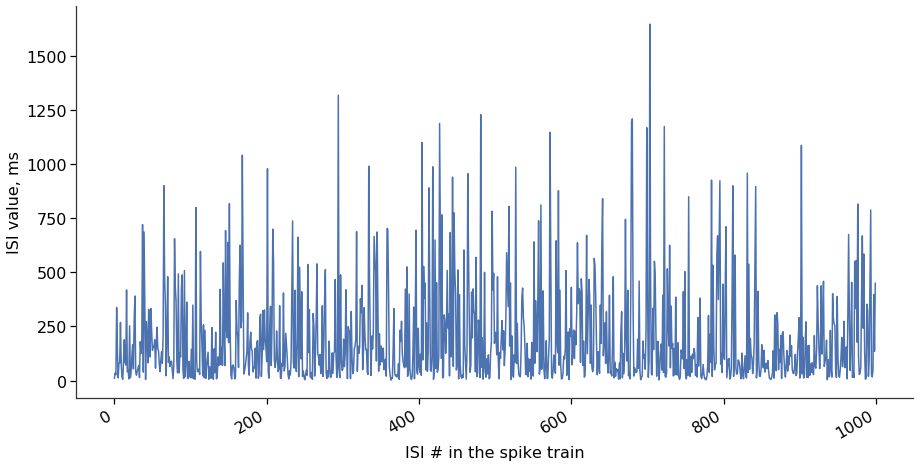

In [8]:
p.plot(data['wake_train']['series'][5][:1000])

p.xlabel('ISI # in the spike train')
p.ylabel('ISI value, ms')

mpladeq.prettify(figsize = (15, 8))

In [9]:
window_size = 100
step_size = 100
total_samples = 5000

crop_data = {}
for key in data:
    crop_data[key] = spkutil.crop_isi_samples(data[key],
                                              window_size=window_size,
                                              step_size=step_size,
                                              total_samples=total_samples)

In [10]:
[(key, crop_data[key]['series'].shape) for key in crop_data]

[('wake_train', (5000, 100)),
 ('wake_test', (5000, 100)),
 ('sleep_train', (5000, 100)),
 ('sleep_test', (5000, 100))]

In [69]:
tsdata = {}

for key in crop_data:
    tsdata[key] = pd.DataFrame(crop_data[key]['series'])

In [70]:
samples = 4500
indices = np.random.choice(total_samples, samples)

X_train = pd.concat([tsdata['wake_train'].iloc[indices, :], tsdata['sleep_train'].iloc[indices, :]])
y_train = np.array([0] * indices.shape[0] + [1] * indices.shape[0])

X_test = pd.concat([tsdata['wake_test'].iloc[indices, :], tsdata['sleep_test'].iloc[indices, :]])
y_test = np.array([0] * indices.shape[0] + [1] * indices.shape[0])

In [74]:
import h2o
from h2o.automl import H2OAutoML

h2o.init(nthreads=-1, max_mem_size=12)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,42 mins 51 secs
H2O cluster timezone:,Europe/Moscow
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,24 days
H2O cluster name:,H2O_from_python_ilazarev_f6e1bk
H2O cluster total nodes:,1
H2O cluster free memory:,10.13 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


In [81]:
frame = pd.concat([X_train.reset_index(drop=True), 
           pd.Series(y_train, name='target')], axis='columns')

In [82]:
frame.columns = [str(name) for name in frame.columns]

In [83]:
X_y_train_h = h2o.H2OFrame(frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [84]:
X_y_train_h.shape

(9000, 101)

In [85]:
X_y_train_h['target'] = X_y_train_h['target'].asfactor()

In [86]:
frame = X_test.reset_index(drop=True)
frame.columns = [str(name) for name in frame.columns]

X_test_h = h2o.H2OFrame(frame)

X_y_train_h.describe()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:9000
Cols:101




,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,target
type,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,enum
mins,0.95,1.0,0.9,1.0,0.95,1.0,0.85,0.9,0.85,1.0,0.85,0.9,1.2,1.05,0.9,0.9,0.9,1.15,0.9,0.9,0.9,1.25,0.9,0.9,0.95,1.0,1.2,1.45,1.05,0.95,0.85,0.95,0.95,1.1,0.85,1.2,0.9,0.9,1.0,0.9,1.4,0.9,0.85,1.0,1.0,0.85,0.85,1.05,0.95,0.9,0.85,0.9,0.85,0.85,1.1,0.85,0.85,0.9,0.85,1.15,0.9,1.55,0.9,0.9,1.0,0.9,1.0,0.9,0.9,0.9,1.1,0.95,0.9,0.9,1.25,1.05,0.9,0.9,1.0,1.1,0.9,0.9,0.85,0.9,1.25,1.1,1.1,1.15,1.05,0.95,1.15,0.85,0.85,0.85,0.85,0.9,0.85,0.9,0.95,0.85,
mean,133.7727777777776,141.05567222222302,135.2574388888892,127.19862222222223,136.42703888888906,147.05434444444458,147.45039444444467,139.10788333333326,141.23625000000018,143.9354166666662,136.8305388888886,141.151216666667,135.64434999999972,139.40757777777728,147.39769999999993,146.7908555555549,133.54218333333299,127.73017777777784,132.2055833333332,146.91072777777774,142.00786111111094,134.56449444444402,147.71791666666644,129.10687222222265,152.62423333333336,137.64495555555519,132.55225000000036,136.3995611111107,137.41642222222185,144.3151722222219,156.7249000000004,137.47399444444383,137.99632222222283,135.42076666666682,131.59550555555546,136.51311666666706,140.56305555555605,137.92456111111116,142.68299999999988,142.39770555555535,147.67158333333342,142.87113333333306,148.4508055555549,130.8381944444445,148.62847222222166,147.39166666666668,141.2253722222218,150.04119444444422,139.94471111111045,135.18391111111166,123.12290000000012,130.2846055555557,126.41024999999954,128.9178888888885,130.96184999999986,131.08523888888914,132.41028333333367,145.02213888888883,135.64830000000038,139.1447388888892,139.02137777777713,150.55816666666644,140.78991666666676,148.19042222222174,134.46032777777745,143.1545888888893,132.35075555555542,126.48240555555498,145.3923833333332,125.80794999999985,134.75587777777795,151.47023888888864,135.84315555555594,136.6096333333337,135.90501666666646,129.89521666666658,146.8475888888887,129.53245000000013,131.00982222222183,145.2477388888892,136.6821499999996,137.27108333333328,134.34611111111107,143.01717777777787,134.80530000000016,142.79927222222216,130.27069999999986,136.89287222222225,132.83621666666656,141.75653888888948,150.41822777777782,129.5140888888886,148.35112222222233,129.05420555555563,129.1570388888888,131.02237222222226,138.28445000000022,129.05789999999928,150.41551111111136,143.53392222222175,
maxs,11989.6,15697.35,11862.2,7982.0,21435.5,47897.75,35509.6,11551.7,21806.75,24620.65,20207.05,9509.2,15953.65,16293.35,26679.15,11798.8,8838.0,6504.75,23117.95,39514.05,35374.6,9775.0,9562.7,9670.35,35174.7,11369.65,9640.25,14135.85,16903.65,14979.3,36101.8,10631.6,7347.0,14209.0,6164.5,13539.1,7944.85,15686.75,15742.3,19236.05,12354.25,26132.05,23549.7,18499.6,18907.15,22987.4,23264.55,22829.45,11404.6,9788.7,11503.4,17657.1,12852.1,10525.9,9668.35,9035.8,10014.45,19269.75,7862.1,11210.85,13773.4,24699.35,16787.3,30774.95,16393.9,44443.5,14808.05,6871.0,43750.2,8104.1,13684.9,40086.45,14179.0,9909.75,5501.6,13648.95,13459.9,12180.55,12200.15,17882.2,13840.7,10607.85,13271.75,24596.6,8195.35,13110.6,14767.35,14615.9,12832.85,14190.05,21608.7,8666.3,14809.2,11241.65,12320.7,11773.45,7698.3,12629.0,17395.25,10758.05,
sigma,428.11421504491045,498.7

In [88]:
! mkdir -p h2o_models_raw-fcx-1

In [98]:
aml = H2OAutoML(max_runtime_secs=1000,
                max_models=None,
                seed=42)

In [99]:
X_y_train_h.as_data_frame()['target'].mean()

0.5

In [100]:
aml.train(x=list(frame.columns.values),
          y='target',
          training_frame=X_y_train_h)

lb = aml.leaderboard
model_ids = list(lb['model_id'].as_data_frame().iloc[:, 0])
out_path = "./h2o_models_raw-fcx-1"

for m_id in model_ids:
    mdl = h2o.get_model(m_id)
    h2o.save_model(model=mdl, path=out_path, force=True)

h2o.export_file(lb, osp.join(out_path, 'aml_leaderboard.h2o'), force=True)

AutoML progress: |████████████████████████████████████████████████████████| 100%
Export File progress: |███████████████████████████████████████████████████| 100%


In [102]:
models_path = "./h2o_models_raw-fcx-1"

lb = h2o.import_file(path=os.path.join(models_path, "aml_leaderboard.h2o"))

lb.shape

Parse progress: |█████████████████████████████████████████████████████████| 100%


(27, 6)

In [103]:
lb = lb.as_data_frame()

In [104]:
lb.head()

,model_id,auc,logloss,mean_per_class_error,rmse,mse
0,StackedEnsemble_BestOfFamily_AutoML_20191201_2...,0.967173,0.241141,0.111111,0.275312,0.075796
1,GBM_4_AutoML_20191201_220107,0.965950,0.241823,0.114778,0.279860,0.078321
2,GBM_3_AutoML_20191201_220107,0.964487,0.245481,0.113111,0.277768,0.077155
3,GBM_2_AutoML_20191201_220107,0.962535,0.251898,0.110667,0.278964,0.077821
4,XGBoost_1_AutoML_20191201_220107,0.959177,0.266297,0.114000,0.281593,0.079295


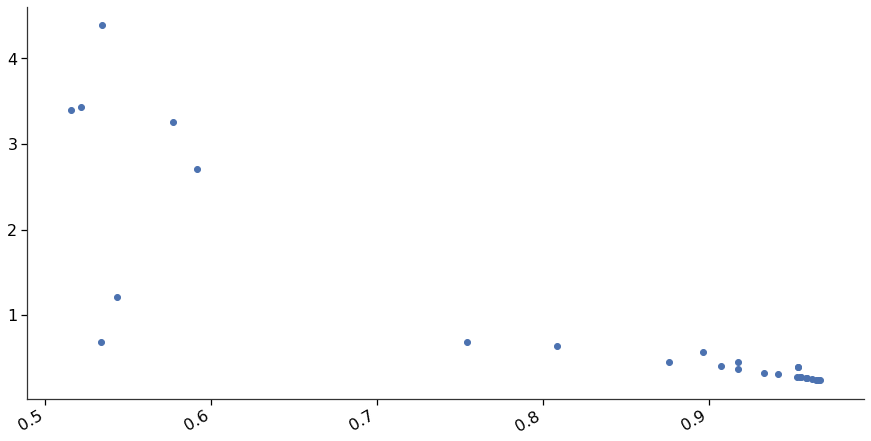

In [105]:
p.scatter(lb['auc'], lb['logloss'])

mpladeq.prettify(figsize = (15, 8))